In [1]:
import dataset_creation as dsc
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.layers.preprocessing.text_vectorization import TextVectorization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
# UNCOMMENT TO BUILD DATASET FROM SCRATCH

# corpus = {
#     'juv_sat' : (['corpus/IVV-satu-no-ojf.xml'], 'Juvenal', 'Satires', None),
#     'luc_phar' : (['corpus/LVCAN-phar.xml'], 'Lucan', 'Pharsalia', None),
#     'ov_met' : (['corpus/OV-meta.xml'],'Ovid', 'Metamorphoses', None),
#     'sil_puni' : (['corpus/SIL-puni.xml'], 'Silius', 'Punica', None),
#     'stat_theb' : (['corpus/STAT-theb.xml'], 'Statius', 'Thebaid', None),
#     'flac_argo' : (['corpus/VAL_FL-argo.xml'], 'V. Flaccus', 'Argonautica', None),
#     'verg_aen' : (['corpus/VERG-aene.xml'], 'Vergil', 'Aeneid', None),
#     'lucr_dnr' : (['corpus/LVCR-rena.xml'], 'Lucretius', 'De Rerum Natura', None),
#     'verg_geo' : (['corpus/VERG-geor.xml'], 'Vergil', 'Georgics', None),
#     'hor_sat' : (['corpus/HOR-sat1.xml', 'corpus/HOR-sat2.xml'], 'Horace', 'Satires', None)
# }

# train_64_aug, test_64_aug = dsc.chunked_dataset(
#     chunk=64,
#     step=4,
#     corpus=corpus,
#     mapper=dsc.lines_to_aug_sylstream,
#     return_raw=False
# )

In [3]:
# UNCOMMENT TO UPDATE SAVED DATASET
#
# train_64_aug.to_pickle('train_64_aug.pkl')
# test_64_aug.to_pickle('test_64_aug.pkl')

In [4]:
train_64_aug = pd.read_pickle('train_64_aug.pkl')
test_64_aug = pd.read_pickle('test_64_aug.pkl')

In [5]:
# Used by both models

encoder = tf.keras.layers.TextVectorization(standardize=None)
encoder.adapt(train_64_aug.Chunk)

batch_size = 32
shuf_size = len(train_64_aug.Chunk)

chunk_len, n_classes = (len(train_64_aug.Chunk[0].split(" ")), len(train_64_aug.Author.unique()))

2022-11-28 15:46:41.935751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:46:42.495002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21351 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


# PART 1, CNN Models

## Padding approach for CNN 

We have lines of syllables, max in theory is 18 min is 12 (in practice the last
two feet are DS so the numbers are 13 and 17). CNNs work best with some padding
on both sides so 'pixels' at the edges have a fair chance to influence the
result (they appear in more sliding windows). Since each line has a different
number of syllables we pad left with two zeroes and right to a total length of
20. (2 + 17 + 1 for hypermetrics)

Since we need to manually pad everything to 20 syllables, we can't use tf
padded_batch because that gives us different padding for every batch.

In [6]:
def eol_indices(chunk: str) -> list[int]:
    '''
    Take a single chunk (space separated encoded tokens) and return the indices
    of the ends of lines, so we know where to start padding for each line
    '''
    sary = chunk.split(' ')
    idx_ary = np.where(np.array(sary)=='EOL')[0]
    # build an array of indices that can be used as successive [from:to] indices
    # for python slices, so the first pair should start at 0 and the final one
    # should end at len(v_enc). Since all the EOL indices we have need to be
    # incremented by one anyway we hack around a bit to get the correct final
    # list
    idx_ary = np.concatenate([[-1],idx_ary,[len(sary)]]) + 1
    return idx_ary
    
def chunk_to_ndarray(chunk: str, enc: TextVectorization):
    '''
    Take a chunk of string tokens, and an encoder, and return an np.ndarray of
    n_lines x 20, padded left with [0,0] and right with as many 0s as needed to
    reach 20. ndarray is a 'native' type to convert to a tf tensor.
    '''
    encoded = enc(chunk)
    idx_ary = eol_indices(chunk)
    lines = [encoded[idx_ary[i]:idx_ary[i+1]] for i in range(len(idx_ary)-2)]
    # build an array of zeroes
    padded = np.zeros((len(lines), 20),dtype=int)
    # then overwrite with the tokens, untouched 0s become padding
    for i, row in enumerate(lines):
        padded[i, 2:(len(row)+2)] = row 
    return padded



In [7]:
# this is super slow :/ It would be better to vectorize chunk_to_ndarray, but
# it's hard and we only run it once (the types are annoying to map to tf native
# stuff, PRs welcome ;)

train = [chunk_to_ndarray(x,encoder) for x in train_64_aug.Chunk]
test = [chunk_to_ndarray(x,encoder) for x in test_64_aug.Chunk]

ds_train_cnn = tf.data.Dataset.from_tensor_slices((train, train_64_aug.Factor.tolist()))
ds_test_cnn = tf.data.Dataset.from_tensor_slices((test, test_64_aug.Factor.tolist()))

ds_test_cnn  = ds_test_cnn.cache()
ds_test_cnn  = ds_test_cnn.batch(batch_size)
ds_test_cnn  = ds_test_cnn.prefetch(tf.data.experimental.AUTOTUNE)

ds_train_cnn = ds_train_cnn.cache()
ds_train_cnn = ds_train_cnn.shuffle(shuf_size, reshuffle_each_iteration=True)
ds_train_cnn = ds_train_cnn.batch(batch_size)
ds_train_cnn = ds_train_cnn.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
BASE_LEARNING_RATE = 0.0001

In [9]:
def reset_cnn() -> tf.keras.models.Sequential:
  '''
  (re)build the CNN model. Many model configs work fine, this is just one that
  performed roughly as well as the best few dozen I tried.
  '''
  cnn = tf.keras.models.Sequential(
    [
      # need to flatten to embed for some reason
      tf.keras.layers.Flatten(),
      tf.keras.layers.Embedding(
          name='embed',
          input_dim=len(encoder.get_vocabulary()),
          output_dim=32,
      ),
      tf.keras.layers.Reshape((64,20,32)),
      tf.keras.layers.Dropout(0.25),
      # wider than long to de-emphasise distance vertical relationships
      tf.keras.layers.Conv2D(
        24,
        kernel_size=(4,2),
        activation='relu',
        padding='same',
        name='conv1'
        ),
      tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),
      tf.keras.layers.BatchNormalization(name='norm1'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(
        48,
        kernel_size=(4,2),
        activation='relu',
        padding='same',
        name='conv2'
        ),
      tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),
      tf.keras.layers.BatchNormalization(name='norm2'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, name='dense1'),
      tf.keras.layers.Dense(64, name='dense2'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(
        n_classes,
        activation='softmax',
        name='classify')
    ],
    name='cnn'
  )
  cnn.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      metrics=['accuracy'],
  )
  cnn.build((None,64,20))
  return cnn

In [10]:
def change_lr(m, new_lr):
  '''
  quality of life function to modify learning rate
  '''
  m.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=new_lr),
    metrics=['accuracy'],
  )
  return m

def es(n):
  '''
  quality of life function to get EarlyStopping callbacks with various patience
  levels
  '''
  return tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=n,
    restore_best_weights=True
  )

In [11]:
def draw_cm(model, test_set, test_df):
    '''
    draw a quick and dirty confusion matrix in the notebook. At the moment I
    don't really care about classification accuracy per se it's just a proxy to
    know that the model understands authorial style, but it's good to have to
    make sure nothing is going crazy.
    '''
    plt.rcParams["figure.figsize"] = (8,8)
    plt.rcParams["figure.dpi"] = 72

    pred = [np.argmax(preds) for preds in model.predict(test_set)]
    cm = confusion_matrix(test_df.Factor, pred)
    cm = np.array([(row/sum(row))*100 for row in cm])

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=sorted(test_df.Author.unique())
        )
    disp.plot(values_format='.1f')
    disp.im_.colorbar.remove()

    plt.show()

In [12]:
tf.random.set_seed(42)

In [13]:
cnn = reset_cnn()
cnn = change_lr(cnn, BASE_LEARNING_RATE)

In [14]:
history_cnn_initial = cnn.fit(
    ds_train_cnn,
    epochs=100,
    verbose=0,
    validation_data=ds_test_cnn,
    callbacks=[es(8)]
)

2022-11-28 15:51:51.634055: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-11-28 15:51:53.160186: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<AxesSubplot:>

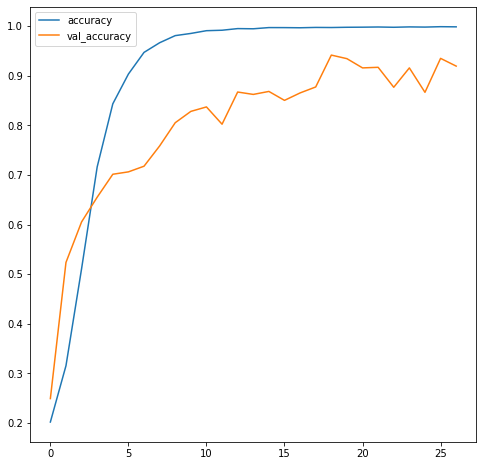

In [15]:
pd.DataFrame(history_cnn_initial.history).plot.line(y=['accuracy','val_accuracy'],figsize=(8,8))

In [16]:
cnn.evaluate(ds_test_cnn)

53/53 [==============================] - 0s 5ms/step - loss: 0.2378 - accuracy: 0.9417


[0.23783454298973083, 0.9417417645454407]

53/53 [==============================] - 0s 3ms/step


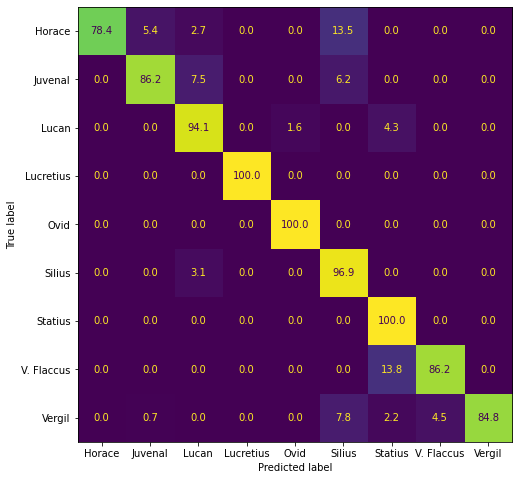

In [17]:
draw_cm(cnn, ds_test_cnn, test_64_aug)

In [19]:
# On the first run, the model has overfit, but we can save the embeddings, and
# retrain the model weights from scratch to get more improvement.

# save those embedding weights, and train again
w = cnn.get_layer('embed').get_weights()
cnn = reset_cnn()
cnn.get_layer('embed').set_weights(w)

# Retrain, but lower learning rate. Freeze the embeddings now.
cnn = change_lr(cnn, BASE_LEARNING_RATE/2)
cnn.get_layer('embed').trainable = False

history_trained = cnn.fit(
    ds_train_cnn,
    epochs=100,
    verbose=0,
    validation_data=ds_test_cnn,
    callbacks=[es(15)]
)


<AxesSubplot:>

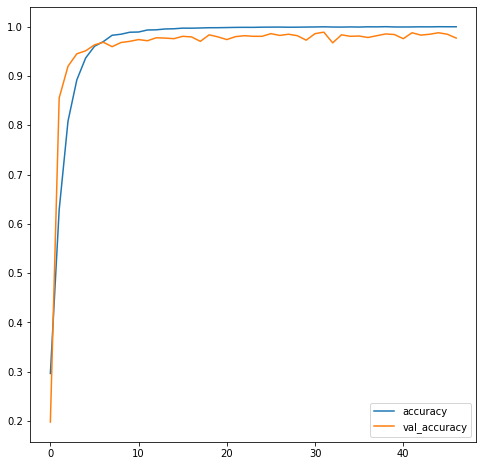

In [20]:
pd.DataFrame(history_trained.history).plot.line(y=['accuracy','val_accuracy'],figsize=(8,8))

In [22]:
cnn.evaluate(ds_test_cnn)

53/53 [==============================] - 0s 5ms/step - loss: 0.0662 - accuracy: 0.9886


[0.06619356572628021, 0.9885885715484619]

53/53 [==============================] - 0s 3ms/step


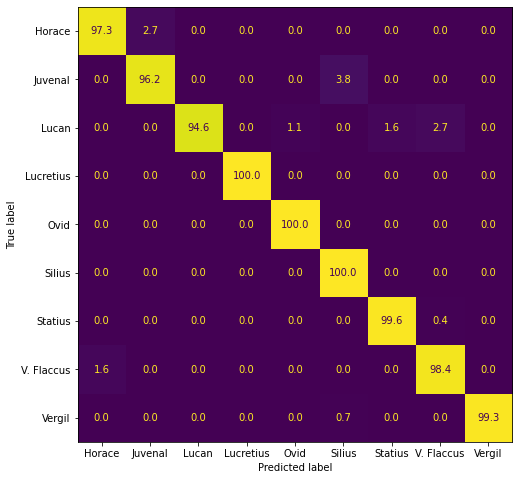

In [23]:
draw_cm(cnn, ds_test_cnn, test_64_aug)

In [ ]:
# UNCOMMENT TO UPDATE SAVED MODEL

# cnn.save('cnn_aug_64_emb32')
#
# cnn_embed = tf.keras.Sequential(
#     [
#         tf.keras.layers.Embedding(
#             input_dim=len(encoder.get_vocabulary()),
#             output_dim=32,
#             name='embed'
#         ),
#     ],
#     name='cnn_embedder_32'
# )

# w = cnn.get_layer('embed').get_weights()
# cnn_embed.get_layer('embed').set_weights(w)

# cnn_embed.save('cnn_embedder_32')

# PART 2, LSTM Models

For LSTM models we treat the chunk as a single string of syllables (1D) padded at the end. Since this is what RNNs are built for it's a bit easier. TF has a padded_batch mode for the datasets that pads each batch to the max length per batch and also masks the padding so the model doesn't fit on it.

In [26]:
def vectorize_text(text, label):
    return encoder(text), label

In [27]:
ds_train_lstm = tf.data.Dataset.from_tensor_slices((train_64_aug.Chunk.tolist(), train_64_aug.Factor.tolist()))
ds_test_lstm= tf.data.Dataset.from_tensor_slices((test_64_aug.Chunk.tolist(), test_64_aug.Factor.tolist()))

ds_test_lstm = ds_test_lstm.map(vectorize_text)
ds_test_lstm = ds_test_lstm.cache()
# Since we take chunks by lines, now, the syllable count will not be even. tf
# provides a nice mapper for this, which pads by default to the length of the
# longest chunk with zeros. Those zeros are later masked out by the embedding
# layer, which is all pretty slick.
ds_test_lstm = ds_test_lstm.padded_batch(batch_size)
ds_test_lstm = ds_test_lstm.prefetch(tf.data.experimental.AUTOTUNE)

ds_train_lstm = ds_train_lstm.map(vectorize_text)
ds_train_lstm = ds_train_lstm.cache()
ds_train_lstm = ds_train_lstm.shuffle(shuf_size, reshuffle_each_iteration=True)
ds_train_lstm = ds_train_lstm.padded_batch(batch_size)
ds_train_lstm = ds_train_lstm.prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
def reset_lstm() -> tf.keras.models.Sequential:
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Embedding(
                input_dim=len(encoder.get_vocabulary()),
                output_dim=32,
                mask_zero=True,
                name='embed'
            ),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(32,return_sequences=True),
                name='lstm1'
                ),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(32, name='lstm2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation="relu", name='dense'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(
                n_classes,
                activation="softmax",
                name='classify'
                ),
        ],
        name='lstm_64_emb32'
    )

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=["accuracy"],
    )

    return model

In [42]:
lstm = reset_lstm()

history_lstm_initial = lstm.fit(
    ds_train_lstm,
    epochs=100,
    verbose=0,
    validation_data=ds_test_lstm,
    callbacks=[es(10)]
)

In [43]:
lstm.evaluate(ds_test_lstm)

53/53 [==============================] - 4s 82ms/step - loss: 0.2055 - accuracy: 0.9435


[0.20552030205726624, 0.943543553352356]

<AxesSubplot:>

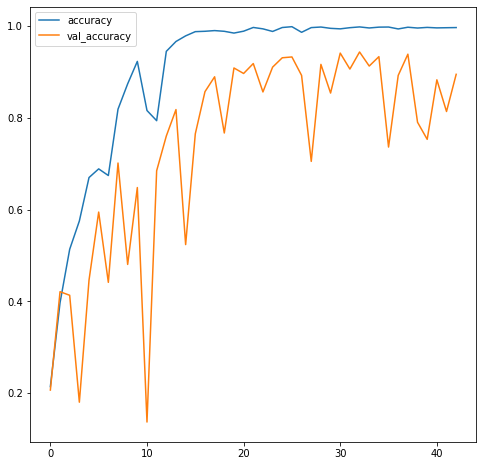

In [44]:
pd.DataFrame(history_lstm_initial.history).plot.line(y=['accuracy','val_accuracy'],figsize=(8,8))

53/53 [==============================] - 9s 80ms/step


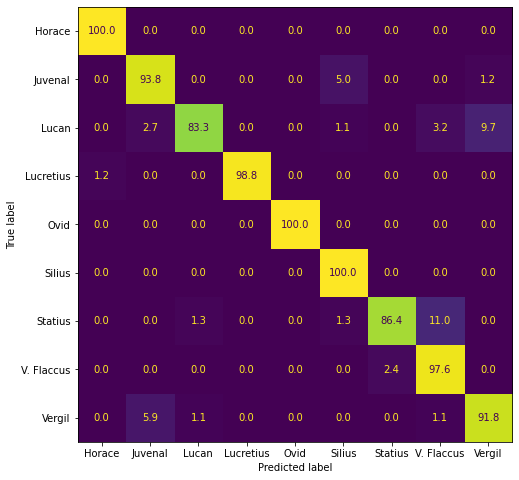

In [45]:
draw_cm(lstm, ds_test_lstm, test_64_aug)

In [46]:
# save those embedding weights, and train again
w = lstm.get_layer('embed').get_weights()
lstm = reset_lstm()
lstm.get_layer('embed').set_weights(w)

# Freeze the embeddings now.
# For the LSTM lowering the learning rate here doesn't help
lstm.get_layer('embed').trainable = False

history_lstm_trained = lstm.fit(
    ds_train_lstm,
    epochs=100,
    verbose=0,
    validation_data=ds_test_lstm,
    callbacks=[es(10)]
)

In [47]:
lstm.evaluate(ds_test_lstm)

53/53 [==============================] - 4s 83ms/step - loss: 0.1358 - accuracy: 0.9790


[0.1358150839805603, 0.9789789915084839]

<AxesSubplot:>

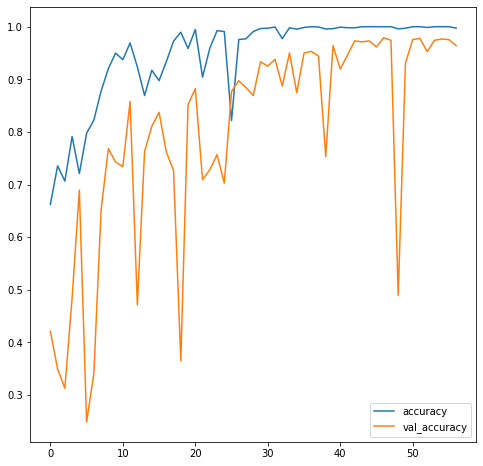

In [48]:
pd.DataFrame(history_lstm_trained.history).plot.line(y=['accuracy','val_accuracy'],figsize=(8,8))

53/53 [==============================] - 8s 83ms/step


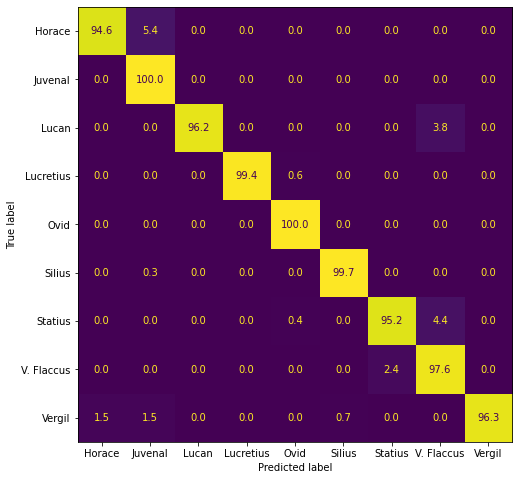

In [49]:
draw_cm(lstm, ds_test_lstm, test_64_aug)

In [54]:
# UNCOMMENT TO UPDATE SAVED MODELS

# lstm.save('lstm_aug_64_emb32')

# lstm_embed = tf.keras.Sequential(
#     [
#         tf.keras.layers.Embedding(
#             input_dim=len(encoder.get_vocabulary()),
#             output_dim=32,
#             name='embed'
#         ),
#     ],
#     name='lstm_embedder_32'
# )
#
# w = lstm.get_layer('embed').get_weights()
# lstm_embed.get_layer('embed').set_weights(w)
#
# lstm_embed.save('lstm_embedder_32')